In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import transforms
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import os
import argparse
from sklearn.metrics import *
%matplotlib inline
os.environ['KMP_DUPLICATE_LIB_OK']='True'


# define the hyper-parameters
batch_size = 1000
learning_rate = 1e-3
num_epoches = 70
loss_list = [] #  save loss
accuracy_list = [] # save accuracy
iteration_list = []


output_prob = []

In [2]:
# download the FashionMNIST dataset

train_dataset = datasets.FashionMNIST(
    root='./data/FashionMNIST', train=True, transform=transforms.ToTensor(), download=True)

test_dataset = datasets.FashionMNIST(
    root='./data/FashionMNIST', train=False, transform=transforms.ToTensor(),
    download=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [3]:
# check the class types and labels

class_names = train_dataset.classes 
print(class_names)
print(train_dataset.data.shape)
print(test_dataset.data.shape)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])


In [4]:
BATCH_SIZE = 32 
EPOCHS = 1

In [5]:
#computing vector embeddings for finite sets of items.

import pymde

fashion_mnist = pymde.datasets.FashionMNIST()
# embedding = pymde.preserve_neighbors(fashion_mnist.data, verbose=True).embed()
# pymde.plot(embedding, color_by=fashion_mnist.attributes['class'])

In [6]:
fashion_mnist

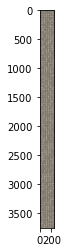

In [7]:
images, labels = next(iter(test_loader))

#  show some samples of data 

def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406]) 
    std = np.array([0.229, 0.224, 0.225]) 
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1) 
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    
    
out = torchvision.utils.make_grid(images)

imshow(out)

In [8]:
import torch.nn.functional as F

# define the CNN model
class LeNetVariant(nn.Module):
    def __init__(self):
        super(LeNetVariant, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout2d()
        )
        self.classifier = nn.Sequential(nn.Linear(32 * 4 * 4, 32))

    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, 32 * 4 * 4 )
        x = self.classifier(x)
        return x

# define the CNN+LSTM model
class CNNLSTM(nn.Module):
    def __init__(self, num_classes=2):
        super(CNNLSTM, self).__init__()
        self.cnn = LeNetVariant()
        self.lstm = nn.LSTM(input_size=32, hidden_size=160, num_layers=1,
                            batch_first=True)
        self.fc1 = nn.Linear(160, num_classes)

    def forward(self, x_3d):
        cnn_output_list = list()
        for t in range(x_3d.size(1)):
            cnn_output_list.append(self.cnn(x_3d[:, t, :, :, :]))
        x = torch.stack(tuple(cnn_output_list), dim=1)
        out, hidden = self.lstm(x)
        x = out[:, -1, :]
        x = F.relu(x)
        x = self.fc1(x)
        return F.log_softmax(x, dim=1)

In [9]:
# define the train steps
def train_loop(dataloader, model, loss_fn, optimizer, which_model):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X = X.unsqueeze(1)
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch % 50 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        

# define the test steps
def test_loop(dataloader, model, loss_fn, which_model):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
        
            X = X.unsqueeze(1)
            pred = model(X)
            output_prob.append(pred.tolist())
            
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    loss_list.append(test_loss)
    accuracy_list.append(correct * 100)
    
    print(f"Test Error: \n Accuracy: {(100 * correct):>0.2f}%, "
          f"Avg loss: {test_loss:>8f} \n")

In [10]:
# Start to train the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model = CNNLSTM(num_classes=10).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


for t in range(num_epoches):
    print(f"Epoch {t + 1}\n-------------------------------")
    train_loop(train_loader, model, loss_fn, optimizer, 2)
    test_loop(test_loader, model, loss_fn, 2)
    print("Done!")
    
    
# Save Models
torch.save(model.state_dict(), "cnnlstm.pth")
print("Saved PyTorch Model State to cnnlstm.pth")

Epoch 1
-------------------------------
loss: 2.302523  [    0/60000]
loss: 1.124304  [50000/60000]
Test Error: 
 Accuracy: 62.31%, Avg loss: 1.054696 

Done!
Epoch 2
-------------------------------
loss: 1.025688  [    0/60000]
loss: 0.770436  [50000/60000]
Test Error: 
 Accuracy: 72.40%, Avg loss: 0.752992 

Done!
Saved PyTorch Model State to cnnlstm.pth


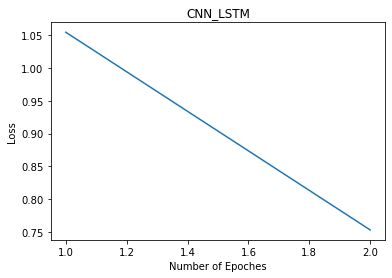

In [11]:
# draw the graph of the loss

for i in range(num_epoches):
    iteration_list.append(i+1)

plt.plot(iteration_list, loss_list)
plt.xlabel('Number of Epoches')
plt.ylabel('Loss')
plt.title('CNN_LSTM')
plt.show()

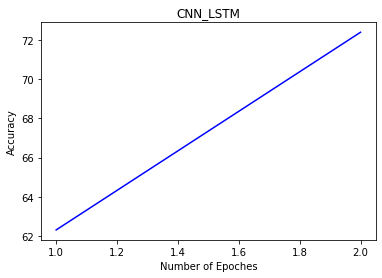

In [12]:
# draw the graph of the accuracy

plt.plot(iteration_list, accuracy_list, color='b')
plt.xlabel('Number of Epoches')
plt.ylabel('Accuracy')
plt.title('CNN_LSTM')
#plt.savefig('LSTM_accuracy2.png')
plt.show()

In [13]:
# Compute the confusion matrix and F1_score, Acc, Recall_rate, and Precision

def test_label_predictions(model, device, test_loader):
    model.eval()
    actuals = []
    predictions = []
    with torch.no_grad():
        for data, target in test_loader:
            
            data = data.unsqueeze(1)
            output = model(data)
            prediction = output.argmax(dim=1, keepdim=True)
            actuals.extend(target.view_as(prediction))
            predictions.extend(prediction)
    return [i.item() for i in actuals], [i.item() for i in predictions]

actuals, predictions = test_label_predictions(model, device, test_loader)
k = confusion_matrix(actuals, predictions)
print('Confusion matrix:')
print(k)
print('F1 score: %f' % f1_score(actuals, predictions, average='micro'))
print('Accuracy score: %f' % accuracy_score(actuals, predictions))
print('Recall score: %f' % recall_score(actuals, predictions, average='micro'))
print('Precision score: %f' % precision_score(actuals, predictions, average='weighted'))

Confusion matrix:
[[750   2  31 130  26   5  42   0  14   0]
 [ 13 911   5  55   8   1   6   0   1   0]
 [ 12   0 450  15 445   0  65   0  13   0]
 [ 55  12   6 809  90   1  22   0   5   0]
 [  2   1 125  71 752   0  38   0  11   0]
 [  0   0   0   3   0 878   0  83   8  28]
 [206   1 274  91 325   0  77   0  26   0]
 [  0   0   0   0   0  68   0 833   1  98]
 [  1   3  14   9  28   8   6   3 926   2]
 [  0   0   0   1   0  16   0  39   1 943]]
F1 score: 0.732900
Accuracy score: 0.732900
Recall score: 0.732900
Precision score: 0.720109


In [14]:
np.shape(predictions)

(10000,)

In [16]:
np.shape(output_prob)

(20, 1000, 10)

In [20]:
out_prob = np.reshape(output_prob[(num_epoches-1)*10:num_epoches*10][:][:],(-1, 10))

In [21]:
np.shape(out_prob)

(10000, 10)

In [22]:
import pandas as pd
out_prob = pd.DataFrame(out_prob)

In [24]:
actuals = pd.DataFrame(actuals)
actuals.to_csv('actual_label_LSTM.csv', sep = ',')

In [25]:
np.exp(out_prob).to_csv('output_prob_LSTM.csv', sep = ',')

In [ ]:
print(classification_report(actuals, predictions))

In [ ]:
#draw the heatmap of confusion matrix

import pandas as pd
import seaborn as sns
# Display the confusion matrix as a heatmap
class_names = ['T-shirt/top', 'Trouser', 'Pullover', '  Dress', ' Coat', '  Sandal', ' Shirt', 'Sneaker', ' Bag', 'Ankle boot']
df_cm = pd.DataFrame(k, class_names, class_names)
plt.figure(figsize = (9,6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("Predicted label")
plt.ylabel("Truelabel")
plt.title("confusion matrix")
plt.show()

In [ ]:
#check the ROC and AUROC of a class

import numpy as np


which_class = 6
def test_class_probabilities(model, device, test_loader, which_class):
    model.eval()
    actuals = []
    probabilities = []
    with torch.no_grad():
        for data, target in test_loader:
            data = data.unsqueeze(1)
            output = model(data)
            prediction = output.argmax(dim=1, keepdim=True)
            #setting the target tensor size to same as prediction tensor size
            actuals.extend(target.view_as(prediction) == which_class)
            probabilities.extend(np.exp(output[:, which_class]))
    return [i.item() for i in actuals], [i.item() for i in probabilities]

actuals, class_probabilities = test_class_probabilities(model, device, test_loader, which_class)

fpr, tpr, _ = roc_curve(actuals, class_probabilities)
roc_auc = auc(fpr, tpr) #Compute the area under the ROC curve.
print('The area under the ROC curve: %f' % roc_auc)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) for digit=%d class' % which_class)
plt.legend(loc="lower right")
plt.show()
#plt.savefig("ROC.png")

In [ ]:
# fashion_mnist = pymde.datasets.FashionMNIST()
# embedding = pymde.preserve_neighbors(fashion_mnist.data, verbose=True).embed()
# pymde.plot(embedding, color_by=mnist.attributes['class'])